# Cats v/s Dogs Classification

### Note - Change runtime to GPU

## Imports

In [ ]:
import os
from zipfile import ZipFile
import shutil
import random

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
print(tf.version.VERSION)

2.2.0


## Dataset Prep

### Get the Dataset
1. Download the Dataset from here - https://www.kaggle.com/c/dogs-vs-cats/data.  
2. Upload it to your Google Drive and then use the following code to mount the dataset on Google Colab  
a. !cp '/content/gdrive/My Drive/< file_path_on_google_drive >' < file_path_in_colab >

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Datasets/dogs-vs-cats.zip' '/tmp/dogs-vs-cats.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Unzip the data

In [ ]:
zip_location = '/tmp/dogs-vs-cats.zip'

with ZipFile(zip_location, 'r') as zip:
  zip.extractall('/tmp')

FileNotFoundError: ignored

In [ ]:
train_zip_location = '/tmp/train.zip'
test_zip_location = '/tmp/test1.zip'
test_csv_location = '/tmp/sampleSubmission.csv'

In [ ]:
with ZipFile(train_zip_location, 'r') as zip:
  zip.extractall('/tmp')

In [ ]:
with ZipFile(test_zip_location, 'r') as zip:
  zip.extractall('/tmp')

### Define Paths and Create Directories

In [ ]:
base_path = '/tmp'

source_path = os.path.join(base_path, 'train') 

train_path = os.path.join(base_path, 'training')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test1')

train_cats_dir = os.path.join(train_path, 'cats')
train_dogs_dir = os.path.join(train_path, 'dogs')

validation_cats_dir = os.path.join(validation_path, 'cats')
validation_dogs_dir = os.path.join(validation_path, 'dogs')

In [ ]:
try:
  os.mkdir(train_path)
  os.mkdir(validation_path)
  os.mkdir(train_cats_dir)
  os.mkdir(train_dogs_dir)
  os.mkdir(validation_cats_dir)
  os.mkdir(validation_dogs_dir)
except OSError:
  pass

### Use 90% of Files for Training and 10% for Validation 

In [ ]:
def copyfiles(source, list_of_files, train_dir, validation_dir, split_ratio=0.9):
  random.shuffle(list_of_files)
  split = int(len(list_of_files)*split_ratio)
  train_data, validation_data = list_of_files[:split], list_of_files[split:]

  for filename in train_data:
    shutil.copyfile(os.path.join(source,filename), os.path.join(train_dir,filename))
  
  for filename in validation_data:
    shutil.copyfile(os.path.join(source,filename), os.path.join(validation_dir,filename))


In [ ]:
def split_data(source, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, split_ratio = 0.9):
  all_files = os.listdir(source)
  cat_files = []
  dog_files = []

  for filename in all_files:
    temp = filename.split('.')
    if temp[0] == 'cat':
      cat_files.append(filename)
    else:
      dog_files.append(filename)

  copyfiles(source, cat_files, train_cats_dir, validation_cats_dir, split_ratio)
  copyfiles(source, dog_files, train_dogs_dir, validation_dogs_dir, split_ratio)

  return


In [ ]:
split_data(source_path, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, 0.9)

### Data Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_path, batch_size = 128, class_mode = 'binary', target_size = (150,150))

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(validation_path, batch_size = 128, class_mode = 'binary', target_size = (150, 150))

Found 24758 images belonging to 2 classes.
Found 4758 images belonging to 2 classes.


 ## Training

Using Classes helps when you want to customize your models and it's layers - https://www.tensorflow.org/guide/keras/custom_layers_and_models 

If you want to Improve accuracy further you can try the following
1. Increase Epochs
2. Add Dropouts
3. Add l2 regularization
4. try adding more layers
5. Add Batch Norm
6. Use a PreTrained Model

### Define Model

In [ ]:
class Classifier(Model):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv1 = Conv2D(16, (5,5), activation='relu', padding = 'same')
    self.maxpool = MaxPool2D(2,2)
    self.conv2 = Conv2D(32, (5,5), activation='relu', padding = 'same')
    self.conv3 = Conv2D(64, (3,3), activation='relu', padding = 'same')
    self.conv4 = Conv2D(128, (3,3), activation='relu', padding = 'same')
    self.flatten = Flatten()
    self.dense1 = Dense(512, activation='relu')
    self.dense2 = Dense(1, activation='sigmoid')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.maxpool(x)
    x = self.conv4(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [ ]:
classifier = Classifier()

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.build(input_shape = (128, 150, 150, 3))
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  12832     
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  73856     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5

### Define Callbacks

In [ ]:
# Save Checkpoints in your Drive if you want to restart training for a particular epoch
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/gdrive/My Drive/Checkpoints/cp{epoch:04d}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
  os.mkdir(checkpoint_dir)
except OSError:
  pass

In [ ]:
# Create a callback that saves the model's weights every epoch and keeps the best weights after completion of training
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    save_freq='epoch')

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True, min_delta = 0.001)

### Train

In [ ]:
history = classifier.fit(train_generator, validation_data=validation_generator, epochs = 10, callbacks = [early_stop_callback, cp_callback])

Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5656
Epoch 00001: val_loss improved from inf to 0.65249, saving model to /content/gdrive/My Drive/Checkpoints/cp0001.ckpt
194/194 [==============================] - 184s 947ms/step - loss: 0.6840 - accuracy: 0.5656 - val_loss: 0.6525 - val_accuracy: 0.5801
Epoch 2/10
194/194 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6504
Epoch 00002: val_loss improved from 0.65249 to 0.57254, saving model to /content/gdrive/My Drive/Checkpoints/cp0002.ckpt
194/194 [==============================] - 183s 942ms/step - loss: 0.6213 - accuracy: 0.6504 - val_loss: 0.5725 - val_accuracy: 0.6908
Epoch 3/10
194/194 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.6844
Epoch 00003: val_loss improved from 0.57254 to 0.51552, saving model to /content/gdrive/My Drive/Checkpoints/cp0003.ckpt
194/194 [==============================] - 183s 945ms/step - loss: 0.5870 - accurac

### Freeze Model
We need to Freeze the model before deploying on OpenVino

In [ ]:
for layer in classifier.layers:
  layer.trainable = False

### Save Model
This will save the model's architecture, weights and training configuration. This allows you to export a model o it can be used without access to the original Python code.

Saving a fully-functional model is useful as you can load them in TensorFlow.js, run on mobile devices using TF Lite

In [ ]:
# Save Model in your Drive if you want to restart training for a particular epoch
model_path = "/content/gdrive/My Drive/Models/pet_classification" 
model_dir = os.path.dirname(model_path)

try:
  os.mkdir(model_dir)
except OSError:
  pass

In [ ]:
classifier.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Models/pet_classification/assets


To Load the saved model you can use the following code

In [ ]:
classifier = tf.keras.models.load_model(model_path)

## To Do
1. Add more comments
2. Try Improving val accuracy to 95%
3. Plots
4. (New) add keras tuner
5. Add TensorBoard 

In [ ]:
path1 =  "/content/gdrive/My Drive/images/c2.jpg"

from keras.preprocessing import image
import numpy as np

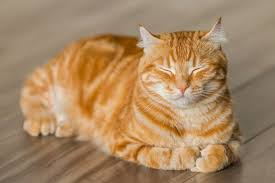

In [ ]:
from IPython.display import Image 

Image(path1)

In [ ]:
img1 = image.load_img(path1, target_size=(150, 150))
img_arr =  image.img_to_array(img1)
x = np.expand_dims(img_arr, axis=0)

In [ ]:
y = classifier.predict(x)[0][0]

In [ ]:
if int(y) == 1:
  print("dog")
else:
  print("cat")

dog
